<a href="https://colab.research.google.com/github/gwohlgen/colab/blob/master/fastai_cooking_multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# fastai cooking 

First test of using **FastAI** with the **cooking dataset**.
This dataset is: **multilabel-label, multi-class, English language**.

For a reference implementation with fasttext: https://fasttext.cc/docs/en/supervised-tutorial.html


What is done:


1.   Create DataBunch
2.   Create data_lm .. data to train the language model
3.   Finetune the AWD_LSTM with the data_lm .. this takes a long time
4.   Train a classifier with the encoder part of the trained language model and the classification dataset








In [117]:
%%html
<marquee style='width: 15%; color: red;font-size:27px'><b>Tipps and tricks!!</b></marquee>

# Tipps and tricks
## About learning rate


*   There are to methods to find the best one: **(Option A)** go the the bottom of the curve, and then devide by 10, **(Option B, Howard)** part with steepest decent.
*   Trick: try 10 times smaller, and 10 times larger of chosen **lr**! Just to see ..

## About weight decay:
* Allow training large NNs without overfitting
* We add the sum (of squared) parameters (weights) to the loss function -- multiplied by the weight decay
* Like that we punish for large weights, and can typically prevent overfitting
* Very cool! Usually wd=0.1 works very well

## About momentum
* When doing eg SGD, the direction is not only the result from the current gradient, but also from the past gradient.
* With momentum, we can say eg 90% of direction is from past, and 10% from current gradient
* It makes the steps larger if we always go in a similar direction. 
* If LR is too marge it also helps to slow it down.
* Past component is "exponentially weighted moving average" .. last time-steps have more weight than older
* really common to have momentum=0.9
* rmsprop (from Hinton), similar, but gradient is squared .. it means: if gradient (steps) are consistent and small --> speed it up!
* **Adam:** does both, momentum and rmsprop
---



## Results:
### LM Top layer:
LR, Epochs (1e-1, 1): 0.2857 acc

LR, Epochs (8e-2, 1): 0.3000 acc

## LM Unfreeze
LR, Epochs (4e-2, 2): 0.2857 acc

LR, Epochs (slice(5e-5, 5e-3), 2): 0.285 acc

## CL Top layer
LR, Epochs (1e-1, 1): 0.69 / 0.047
LR, Epochs (7e-2, 5): 0.46 / 0.01



## Final result:
With large LRs: 0.734792	0.266670

**With very small LRs I didn't get anywhere -- it got stuck in a local min**
**But: training with small LRs all the time, and then training long and hard in the end got good results**: 
0.761397	0.274441
But then, with really aggressive training on the last step (unfreeze all) we get great results, best so far:

44	0.005856	0.100621	0.997487	0.734005	0.338914	00:13

With WD=0.1, and more aggressive LR and long learning:
24	0.007588	0.011348	0.997418	0.741403	0.290017	00:13  # it stabilzes in that region ...


## Data Fetching and Preparation

You can get the data here: 
wget https://dl.fbaipublicfiles.com/fasttext/data/cooking.stackexchange.tar.gz && tar xvzf cooking.stackexchange.tar.gz


In [0]:
# init
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *
import pandas as pd
from pathlib import Path

In [119]:
!wget https://dl.fbaipublicfiles.com/fasttext/data/cooking.stackexchange.tar.gz && tar xvzf cooking.stackexchange.tar.gz

--2019-05-23 12:28:53--  https://dl.fbaipublicfiles.com/fasttext/data/cooking.stackexchange.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.6.166, 104.20.22.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.6.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 457609 (447K) [application/x-tar]
Saving to: ‘cooking.stackexchange.tar.gz.2’

cooking.stackexchan 100%[===================>] 446.88K  2.08MB/s    in 0.2s    

2019-05-23 12:28:54 (2.08 MB/s) - ‘cooking.stackexchange.tar.gz.2’ saved [457609/457609]

cooking.stackexchange.id
cooking.stackexchange.txt
readme.txt


In [120]:
# convert to csv:
data = []

for line in open("cooking.stackexchange.txt"):
    labels = [word for word in line.split(' ') if word.startswith('__label__')]
    text = [word.replace('\n','') for word in line.split(' ') if not word.startswith('__label__')]
    data.append( (' '.join(text), ' '.join(labels) ) )

df = pd.DataFrame(data)
df.columns = ["text", "labels"]

print(df.head)

df.to_csv(r'cooking.stackexchange.csv', index=None, header=True)


<bound method NDFrame.head of                                                     text                                             labels
0      How much does potato starch affect a cheese sa...                     __label__sauce __label__cheese
1      Dangerous pathogens capable of growing in acid...              __label__food-safety __label__acidity
2      How do I cover up the white spots on my cast i...                  __label__cast-iron __label__stove
3      Michelin Three Star Restaurant; but if the che...                                __label__restaurant
4      Without knife skills, how can I quickly and ac...              __label__knife-skills __label__dicing
5                     What's the purpose of a bread box?  __label__storage-method __label__equipment __l...
6      how to seperate peanut oil from roasted peanut...  __label__baking __label__food-safety __label__...
7        American equivalent for British chocolate terms                                 __label__chocolat

or: **Upload the data!**



In [121]:
# check the file is there
!ls cooking*csv

cooking.stackexchange.csv


In [122]:
p = Path('cooking.stackexchange.csv')

df = pd.read_csv('cooking.stackexchange.csv')
print(df.head(2))
print(df.columns)
print(df['text'][1])

                                                text                                 labels
0  How much does potato starch affect a cheese sa...         __label__sauce __label__cheese
1  Dangerous pathogens capable of growing in acid...  __label__food-safety __label__acidity
Index(['text', 'labels'], dtype='object')
Dangerous pathogens capable of growing in acidic environments


## Fine-tuning of the language model

In [123]:
bs=48
data_lm = (TextList.from_csv(Path('.'), 'cooking.stackexchange.csv', cols='text')
           #Inputs: all the text files in path
            # .filter_by_folder(include=['.']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')
print('done')

done


In [0]:

data_lm = load_data(Path('.'), 'data_lm.pkl', bs=bs)

In [125]:
data_lm.show_batch()

idx,text
0,bake vs bake xxbos xxmaj xxunk and balancing of xxunk packed mayonnaise and other sauces xxbos xxmaj what kind of tea do you boil for xxunk ? xxbos xxmaj can i xxup re - freeze chicken soup after it has thawed ? xxbos xxmaj xxunk xxunk bags expand in sous vide xxbos xxmaj what can i use instead of corn syrup ? xxbos xxmaj does soaking almonds have the same
1,xxbos the sugar content of raw corn on the vs cooked corn on the cob xxbos can i bake pine nuts ? xxbos xxmaj should i purchase and use a grease or oil xxunk xxunk ? xxbos xxmaj soy xxmaj sauce storage container xxbos xxmaj xxunk reduced salt in pickling recipe - are these pickles still safe ? xxbos what is an alternative for baking powder ? xxbos xxmaj what
2,salt when brining chicken xxbos xxmaj how concentrated can i brew iced tea ? xxbos xxmaj is it ok to use plastic containers to bake in an electric oven ? xxbos xxmaj how to prevent my roux from sticking to the bottom of the pan ? xxbos xxmaj how can i clean frozen ( raw ) chicken juice out of my freezer ? xxbos xxmaj my gravy turned to jello
3,ginger starting to sprout - can i still use it ? xxbos xxmaj hard boiled eggs outside the fridge xxbos xxmaj why would a portable barbecue xxunk against using pots on the grill ? xxbos xxmaj are chestnut mushrooms and baby xxunk mushrooms the same thing ? xxbos xxmaj adding cold water during cooking of beans and cooking time xxbos xxmaj any reason i ca n't use xxunk batter to
4,not - yet - used frying oil ? xxbos xxmaj dissolving cocoa powder in milk xxbos xxmaj can i cook couscous for a chicken dish in my crock pot at the same time as the chicken ? xxbos xxmaj what are good resources to learn food chemistry ? xxbos xxmaj how to not buy the bad apple ? xxbos xxmaj my own xxmaj xxunk xxbos xxmaj how can i make


In [0]:
# download pre-trained (Wikipedia) model and create learner
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, wd=0.1)

In [127]:
# test lang model
TEXT = "I think"
N_WORDS = 40
N_SENTENCES = 4
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I think An Inch House ( The Long Way to Sun Me ) , a work of art in the Big Three 's House of Style , was a work
I think Great On My Friend ( In a Perfect Sense ) , The New York Times Book Guide ( New York ) : The
I think A Month in My Life ( May months after the United States Red Cross ) and The Day We Were All Right ( May
I think The Heart of Quality ( This Is How i Want You ) ( May / May in the United States ) , The Dark Horse


In [128]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


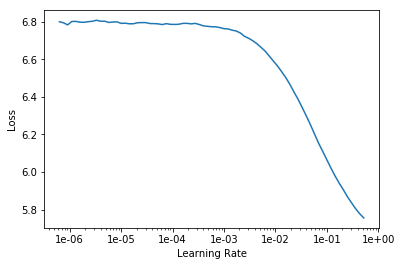

In [129]:
learn.recorder.plot(skip_end=15)

In [130]:
learn.fit_one_cycle(2, 8e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.429375,3.250033,0.328571,00:06
1,3.814278,3.084296,0.371429,00:06


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


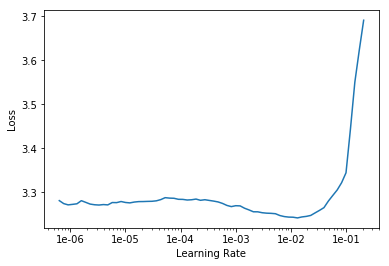

In [134]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [135]:
epochs = 2 # orig: 10
learn.fit_one_cycle(epochs, slice(5e-5, 5e-3) , moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.251272,2.963091,0.385714,00:08
1,3.120081,2.941609,0.385714,00:09


In [0]:
learn.save('fine_tuned')

In [0]:

learn.load('fine_tuned');

In [138]:
# test lang model
TEXT = "I was cooking on"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))


I was cooking on the stove when Spanish toast to take them xxbos What are the effect of cooking a whole duck ? xxbos Why does the water of foods sometimes break when boiling ? xxbos How to make fruit
I was cooking on Short Iron Wok - Look Honeycomb after the fact xxbos Is it better to bake a cookie without * changing the taste of a cooking ? xxbos Can i turn black with rice


In [0]:
learn.save_encoder('fine_tuned_enc')

## Train a classifier

As we are using multi-label classification, we define our own metrics (fastai doesn't support multi-label well yet)

In [0]:
def custom_precision(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(pred_pos.sum() + epsilon))#.item()
  
def custom_recall(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(targs.sum() + epsilon))
 

In [0]:
data_clas = (TextList.from_csv(Path('.'), 'cooking.stackexchange.csv', vocab=data_lm.vocab, cols='text')
             #grab all the text files in path
             #wohlg: .split_by_folder(valid='test')
             .split_by_rand_pct()
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)             
             #wohlg: .label_from_folder(classes=['neg', 'pos'])
             .label_from_df(cols='labels', label_delim=' ')
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')


In [0]:
data_clas = load_data(Path('.'), 'data_clas.pkl', bs=bs)

In [143]:
data_clas.show_batch()
#data_clas.label_list





text,target
"xxbos xxmaj what piece of veal should i xxunk a butcher / meat shop in the xxup us if i want to do stew dishes like "" xxunk de xxunk "" or "" xxunk xxunk "" ?",__label__butchering;__label__cut-of-meat;__label__veal
xxbos i have a xxunk xxunk 4 rib standing rib roast with bone . xxmaj what temp and how long do i cook it in the over ? xxmaj should i use the convection fan ?,__label__beef
"xxbos xxmaj what "" all - in - one "" single serving tea xxunk ) are xxunk , make "" teapot quality "" loose leaf tea , and are two pieces or less ?",__label__equipment;__label__presentation;__label__tea
xxbos xxmaj the bottom of my black cheap pan has worn off and i can now see the metal below where food would go . xxmaj is that pan safe to use anymore ?,__label__food-safety;__label__pan
xxbos xxmaj boiling xxmaj water xxmaj for xxmaj pasta - xxmaj with xxmaj lid xxmaj on xxrep 4 . xxmaj do i xxmaj have xxmaj to xxmaj wash xxmaj the xxmaj lid ?,__label__cleaning


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, wd=0.1)
learn.metrics = [accuracy_thresh, custom_precision, custom_recall]
learn.load_encoder('fine_tuned_enc')

In [145]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


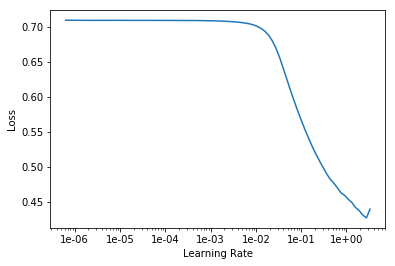

In [146]:
learn.recorder.plot()

In [148]:

learn.fit_one_cycle(3, slice(2e-3,2e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,custom_precision,custom_recall,time
0,0.020889,0.020891,0.996811,0.031169,0.000293,00:07
1,0.019325,0.029013,0.996714,0.002597,0.000120,00:06
2,0.017783,0.017187,0.996816,0.075325,0.000845,00:06


In [0]:
learn.save('first')

In [0]:
learn.load('first');

Why gradual unfreeze? Give example of Image detection.

In [0]:
learn.freeze_to(-2)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


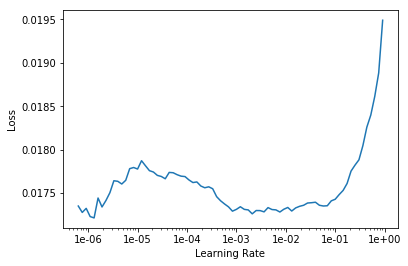

In [152]:
learn.lr_find()
learn.recorder.plot()

In [153]:
# learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.fit_one_cycle(5, 3e-3, moms=(0.8,0.7))

#learn.fit_one_cycle(1, slice(5e-1/(2.6**4),5e-1), moms=(0.8,0.7))
#learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7)

epoch,train_loss,valid_loss,accuracy_thresh,custom_precision,custom_recall,time
0,0.017321,0.017142,0.996817,0.062338,0.000713,00:07
1,0.017076,0.016730,0.996821,0.133766,0.001539,00:07
2,0.016729,0.016270,0.996852,0.574892,0.008464,00:07
3,0.016496,0.016081,0.996873,0.695028,0.020632,00:07
4,0.016273,0.015995,0.996872,0.712171,0.018353,00:07


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
learn.freeze_to(-3)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


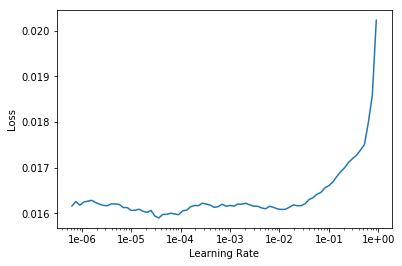

In [157]:
learn.lr_find()
learn.recorder.plot()

In [158]:
#learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
#learn.fit_one_cycle(4, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,custom_precision,custom_recall,time
0,0.016238,0.015916,0.996875,0.739035,0.020283,00:10
1,0.016116,0.015733,0.996896,0.747885,0.025296,00:10
2,0.015922,0.015740,0.996899,0.751912,0.037430,00:10
3,0.015908,0.015507,0.996895,0.737561,0.043764,00:10
4,0.015766,0.015729,0.996927,0.759583,0.042125,00:10


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


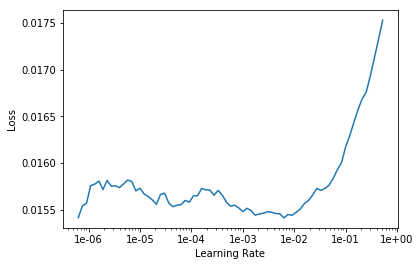

In [162]:
learn.lr_find()
learn.recorder.plot()

In [164]:
learn.fit_one_cycle(30, slice(7e-3/(2.6**4),7e-3), moms=(0.8,0.7)) ## too much??? but in the end it comes in nicely ..
#learn.fit_one_cycle(15, slice(7e-3/(2.6**4),7e-3), moms=(0.8,0.7)) ## works well
#learn.fit_one_cycle(2, slice(3e-4/(2.6**4),3e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,custom_precision,custom_recall,time
0,0.015042,0.014813,0.996975,0.768312,0.059554,00:13
1,0.014880,0.014655,0.997000,0.768995,0.071188,00:13
2,0.014648,0.014348,0.997023,0.789845,0.072955,00:12
3,0.014366,0.014022,0.997090,0.800624,0.097149,00:12
4,0.014168,0.013706,0.997128,0.810262,0.111543,00:13
5,0.013775,0.013305,0.997181,0.806020,0.129804,00:13
6,0.013511,0.013111,0.997219,0.792995,0.156349,00:13
7,0.013019,0.012759,0.997238,0.777531,0.166381,00:13
8,0.012655,0.012531,0.997251,0.774281,0.181992,00:13
9,0.012286,0.017945,0.996476,0.716324,0.207115,00:13


In [0]:
print(learn.predict("Let's make some bread in the oven"))
print(learn.predict("Who likes avocados"))


(MultiCategory __label__bread, tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0

## Evaluate the results
Based on: https://www.kaggle.com/nadjetba/text-to-meaning-with-multi-label-classification?scriptVersionId=12686831

In [0]:
# Predict on the validation dataset
y_pred, y_true =  learn.get_preds()


In [0]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report


In [0]:
f1_score(y_true, y_pred>0.5, average='micro')


0.43283727263884836

In [0]:
f1_score(y_true, y_pred>0.5, average='macro')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.19443526528706617

In [0]:
y_true = y_true.numpy()
scores = y_pred.numpy()
scores.shape, y_true.shape

((3080, 731), (3080, 731))

In [0]:
metrics = classification_report(y_true, scores>0.5, target_names=data_clas.valid_ds.classes)
print(metrics)

                                 precision    recall  f1-score   support

               __label__acidity       0.00      0.00      0.00         6
             __label__additives       0.00      0.00      0.00         2
               __label__african       0.00      0.00      0.00         2
                 __label__aging       0.00      0.00      0.00         0
               __label__alcohol       0.86      0.33      0.48        18
       __label__alcohol-content       0.00      0.00      0.00         0
               __label__alfredo       0.00      0.00      0.00         1
            __label__alkalinity       0.00      0.00      0.00         1
               __label__allergy       0.00      0.00      0.00         9
                __label__allium       0.00      0.00      0.00         0
           __label__almond-milk       0.00      0.00      0.00         0
               __label__almonds       1.00      0.33      0.50         6
     __label__aluminum-cookware       0.00      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
